In [1]:
# Install required packages
%pip install -qU langchain langgraph langgraph-swarm langchain-google-genai langchain_community faiss-cpu tavily-python google-cloud-speech sounddevice scipy pdfminer.six python-dotenv langchain-openai numpy

Note: you may need to restart the kernel to use updated packages.


## 1. Setup and Imports

Install necessary libraries and import required modules.


In [ ]:
# Install required packages (uncomment if needed)
#%pip install -qU langchain langgraph langgraph-swarm langchain-google-genai langchain_community faiss-cpu tavily-python google-cloud-speech sounddevice scipy pdfminer.six python-dotenv langchain-openai

import os
import json
import re
import uuid
import numpy as np
import pandas as pd
import sounddevice as sd
import scipy.io.wavfile as wav
from typing import List, Dict, Any, Optional, TypedDict

# Replace Ollama with Google Generative AI (Gemini)
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
# from langchain_ollama.chat_models import ChatOllama
# from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# Use pydantic.v1 for compatibility as suggested by the warning
from pydantic.v1 import BaseModel, Field 
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_core.tools import tool

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
# Removed unused langgraph_swarm imports

from google.cloud import speech
from pdfminer.high_level import extract_text
from dotenv import load_dotenv

# Load environment variables (for API keys like Tavily, Google Cloud)
load_dotenv()

# --- Configuration ---
FAISS_RESUME_PATH = "./faiss/resume_embeddings"
FAISS_JD_PATH = "./faiss/jd_embeddings"
FAISS_RUBRIC_PATH = "./faiss/rubric_embeddings"
os.makedirs(os.path.dirname(FAISS_RESUME_PATH), exist_ok=True)
os.makedirs(os.path.dirname(FAISS_JD_PATH), exist_ok=True)
os.makedirs(os.path.dirname(FAISS_RUBRIC_PATH), exist_ok=True)

# Retrieve the API key loaded by load_dotenv()
google_api_key = os.getenv("GOOGLE_API_KEY")

# Initialize LLM (using Gemini)
# Pass the API key explicitly
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro",
    temperature=0.1,
    convert_system_message_to_human=True,
    google_api_key=google_api_key
)
# llm = ChatOllama(model="llama3", temperature=0.1)

# Initialize Embeddings Model (using Gemini)
# Pass the API key explicitly
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",
    google_api_key=google_api_key
)
# embeddings = OllamaEmbeddings(model="nomic-embed-text")

# Initialize Checkpointer
memory = InMemorySaver()

Okay, I will update the interview-unlocked.ipynb notebook to implement the agentic workflow described in design.md using `langgraph` and `langgraph_swarm`.

Made changes.

OK. I have populated the interview-unlocked.ipynb notebook with the Python code to implement the multi-agent interview preparation system based on your design.md file and using LangGraph.

The notebook now contains the following sections:

1.  **Setup and Imports:** Installs necessary packages (commented out by default) and imports all required libraries and modules. It also sets up configurations like FAISS paths and initializes the LLM and embedding models.
2.  **Tool Definitions:** Implements all the tools required by the agents, such as text extraction, embedding generation, vector retrieval, web search, LeetCode retrieval (placeholder), audio recording/transcription, and evaluation helper tools (placeholders).
3.  **Agent Definitions:** Defines the `InterviewState` TypedDict to manage the data flow between agents. It includes the prompts for each agent (Preprocessing, Knowledge, Planner, Question, Evaluation) derived from design.md and sets up the agent nodes using LangGraph's `ToolNode` and a helper function.
4.  **Graph Definition:** Constructs the `StateGraph`, adds nodes for each agent and its tools, defines the sequential edges connecting them (Preprocessing -> Knowledge -> Planner -> Question -> Record Answer -> Evaluate -> END), and compiles the graph. It also includes code to optionally visualize the graph structure.
5.  **Execution and Interaction:** Provides an example of how to run the graph. You'll need to **modify the `resume_file` and `jd_file` variables** to point to your actual resume and job description files. It then runs the graph asynchronously, streams the events (like tool calls and LLM outputs), and finally prints the key outputs extracted from the final state (study plan, suggested LeetCode, generated question, transcribed answer, and evaluation feedback).

Please review the notebook, especially the placeholder file paths in the "Execution and Interaction" section, and ensure your environment (API keys, Ollama server if used, Google Cloud credentials) is set up correctly before running the cells.


# Interview Unlocked: Agentic Interview Preparation System

This notebook implements a multi-agent system using LangGraph and LangGraph Swarm to help users prepare for job interviews. It follows the design outlined in `design.md`.


In [ ]:
# --- Tool Implementations ---

@tool
def extract_text_with_ocr(file_path: str) -> str:
    """Extracts text from a file (PDFs supported). Placeholder for OCR if needed."""
    try:
        if file_path.lower().endswith('.pdf'):
            return extract_text(file_path)
        else:
            with open(file_path, 'r', encoding='utf-8') as f:
                return f.read()
    except Exception as e:
        return f"Error extracting text: {e}"

@tool
def generate_resume_embeddings_and_save(text: str) -> str:
    """Generates embeddings for the Job Description text and saves/updates the FAISS JD index."""
    index_path = FAISS_RESUME_PATH # Use the specific path
    try:
        texts = [text] # FAISS expects a list
        if os.path.exists(index_path):
            vectorstore = FAISS.load_local(index_path, embeddings, allow_dangerous_deserialization=True)
            vectorstore.add_texts(texts)
        else:
            vectorstore = FAISS.from_texts(texts, embeddings)
        vectorstore.save_local(index_path)
        return f"JD Embeddings generated and saved to {index_path}"
    except Exception as e:
        return f"Error generating/saving JD embeddings: {e}"

@tool
def generate_jd_embeddings_and_save(text: str) -> str:
    """Generates embeddings for the Job Description text and saves/updates the FAISS JD index."""
    index_path = FAISS_JD_PATH # Use the specific path
    try:
        texts = [text] # FAISS expects a list
        if os.path.exists(index_path):
            vectorstore = FAISS.load_local(index_path, embeddings, allow_dangerous_deserialization=True)
            vectorstore.add_texts(texts)
        else:
            vectorstore = FAISS.from_texts(texts, embeddings)
        vectorstore.save_local(index_path)
        return f"JD Embeddings generated and saved to {index_path}"
    except Exception as e:
        return f"Error generating/saving JD embeddings: {e}"

@tool
def generate_rubric_embeddings_and_save(text: str) -> str:
    """Generates embeddings for the Job Description text and saves/updates the FAISS JD index."""
    index_path = FAISS_RUBRIC_PATH # Use the specific path
    try:
        texts = [text] # FAISS expects a list
        if os.path.exists(index_path):
            vectorstore = FAISS.load_local(index_path, embeddings, allow_dangerous_deserialization=True)
            vectorstore.add_texts(texts)
        else:
            vectorstore = FAISS.from_texts(texts, embeddings)
        vectorstore.save_local(index_path)
        return f"JD Embeddings generated and saved to {index_path}"
    except Exception as e:
        return f"Error generating/saving JD embeddings: {e}"

@tool
def retrieve_resume_embeddings_from_vector_db(query: str, k: int = 3) -> List[str]:
    """Retrieves relevant documents from the resume FAISS index."""
    try:
        index_path = FAISS_RESUME_PATH
        if not os.path.exists(index_path):
            return ["Resume vector index not found."]
        vectorstore = FAISS.load_local(index_path, embeddings, allow_dangerous_deserialization=True)
        results = vectorstore.similarity_search(query, k=k)
        return [doc.page_content for doc in results]
    except Exception as e:
        return [f"Error retrieving from resume vector DB: {e}"]
    
@tool
def retrieve_jd_embeddings_from_vector_db(query: str, k: int = 3) -> List[str]:
    """Retrieves relevant documents from the resume FAISS index."""
    try:
        index_path = FAISS_JD_PATH
        if not os.path.exists(index_path):
            return ["Resume vector index not found."]
        vectorstore = FAISS.load_local(index_path, embeddings, allow_dangerous_deserialization=True)
        results = vectorstore.similarity_search(query, k=k)
        return [doc.page_content for doc in results]
    except Exception as e:
        return [f"Error retrieving from resume vector DB: {e}"]

@tool
def retrieve_rubric_embeddings_from_vector_db(query: str, k: int = 3) -> List[str]:
    """Retrieves relevant documents from the resume FAISS index."""
    try:
        index_path = FAISS_RUBRIC_PATH
        if not os.path.exists(index_path):
            return ["Resume vector index not found."]
        vectorstore = FAISS.load_local(index_path, embeddings, allow_dangerous_deserialization=True)
        results = vectorstore.similarity_search(query, k=k)
        return [doc.page_content for doc in results]
    except Exception as e:
        return [f"Error retrieving from resume vector DB: {e}"]

# Load environment variables from .env file
load_dotenv()

# Retrieve the API key from environment variables
tavily_api_key = os.getenv("TAVILY_API_KEY")

# Check if the API key was loaded
if not tavily_api_key:
    raise ValueError("TAVILY_API_KEY not found in environment variables. Please ensure it is set in your .env file.")

# Tavily Search Tool (already integrated in LangChain)
# Pass the API key during initialization
tavily_tool = TavilySearchResults(tavily_api_key=tavily_api_key, max_results=20)

@tool
def company_leetcode_problem_retriever(company: str, role_keywords: Optional[List[str]] = None) -> List[str]:
    """
    Retrieves suggested LeetCode questions for a specific company by reading
    from the './Leetcode-company-problem-set.xlsx' file. Each company's
    questions are expected to be in a sheet named after the company (case-insensitive).
    Questions are assumed to be listed in the first column (A) starting from the first row (A1).
    The role_keywords parameter is currently unused but available for future filtering.
    """
    excel_path = './Leetcode-company-problem-set.xlsx'
    default_questions = ["Reverse Linked List", "Valid Parentheses", "Coin Change"] # Default if company not found

    print(f"Fetching LeetCode questions for {company} from {excel_path}...")

    try:
        # Check if file exists first
        if not os.path.exists(excel_path):
            print(f"Error: Excel file not found at {excel_path}. Returning default questions.")
            return default_questions

        # Read all sheet names first to handle case-insensitivity
        xls = pd.ExcelFile(excel_path)
        sheet_names = xls.sheet_names
        target_sheet = None
        for name in sheet_names:
            if name.lower() == company.lower():
                target_sheet = name
                break

        if target_sheet:
            # Read the specific sheet, assuming no header and questions start at A1 (index 0)
            df = pd.read_excel(excel_path, sheet_name=target_sheet, header=None)

            if not df.empty and df.shape[1] > 0: # Check if dataframe is not empty and has at least one column
                 # Questions are in the first column (index 0)
                questions = df.iloc[:, 0].dropna().astype(str).tolist()
                if questions:
                    print(f"Found {len(questions)} questions for {company} in sheet '{target_sheet}'.")
                    return questions
                else:
                    print(f"Sheet '{target_sheet}' for {company} found, but the first column is empty or contains only NaN values.")
                    return default_questions
            else:
                print(f"Sheet '{target_sheet}' for {company} found but is empty or has no columns.")
                return default_questions
        else:
            print(f"No specific sheet found for '{company}'. Returning default questions.")
            return default_questions

    except FileNotFoundError: # Should be caught by os.path.exists, but kept for robustness
        print(f"Error: Excel file not found at {excel_path}. Returning default questions.")
        return default_questions
    except Exception as e:
        print(f"An error occurred while reading the Excel file for {company}: {e}. Returning default questions.")
        return default_questions


@tool
def record_and_transcribe_audio(duration: int = 15, fs: int = 16000) -> str:
    """Records audio from the microphone for a specified duration and transcribes it using Google Cloud Speech-to-Text."""
    print(f"Recording audio for {duration} seconds... Speak now!")
    audio_file = f"/tmp/interview_answer_{uuid.uuid4()}.wav"
    try:
        # Record audio
        recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
        sd.wait()
        # Convert to int16 and save
        recording_int16 = np.int16(recording * 32767)
        wav.write(audio_file, fs, recording_int16)
        print("Audio recorded.")

        # Transcribe audio
        print("Transcribing audio...")
        client = speech.SpeechClient() # Assumes GOOGLE_APPLICATION_CREDENTIALS is set
        with open(audio_file, "rb") as f:
            content = f.read()
        audio = speech.RecognitionAudio(content=content)
        config = speech.RecognitionConfig(
            encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
            sample_rate_hertz=fs,
            language_code="en-US",
            enable_automatic_punctuation=True
        )
        response = client.recognize(config=config, audio=audio)
        os.remove(audio_file) # Clean up temporary file

        if not response.results:
            print("Transcription failed: No speech detected.")
            return "[No speech detected]"

        transcript = " ".join([result.alternatives[0].transcript for result in response.results])
        print(f"Transcription complete: {transcript}")
        return transcript.strip()
    except Exception as e:
        if os.path.exists(audio_file):
            os.remove(audio_file)
        error_msg = f"Error during audio recording or transcription: {e}"
        print(error_msg)
        return error_msg

# --- Tools for Evaluation Agent (Simulated - LLM will act based on prompt) ---
# In a full implementation, these might call separate LLMs or specific logic.
@tool
def retrieve_rubric_snippets(query: str, company_tag: str, top_k: int = 3, index_path: str = FAISS_RUBRIC_PATH) -> str:
    """Retrieves relevant rubric snippets from the FAISS index."""
    results = retrieve_from_vector_db(query=f"{query} {company_tag}", index_path=index_path, k=top_k)
    return "\n".join(results)

@tool
def generate_ideal_answer(question: str, company_tag: Optional[str] = None) -> str:
    """Generates an ideal answer to the question (simulated by LLM call)."""
    # This would typically involve another LLM call with specific instructions
    # For simplicity here, we'll just return a placeholder or let the main agent handle it.
    return f"[Placeholder: Ideal answer generation for '{question}' considering company '{company_tag}']"

@tool
def rewrite_candidate_answer(question: str, candidate_answer: str) -> str:
    """Rewrites the candidate's answer for improvement (simulated by LLM call)."""
    return f"[Placeholder: Rewritten version of answer for '{question}']"

@tool
def critique_and_advise(question: str, candidate_answer: str, ideal_answer: str, company_tag: Optional[str] = None) -> str:
    """Provides critique and advice based on the answers (simulated by LLM call)."""
    return f"[Placeholder: Critique for answer to '{question}' considering company '{company_tag}']"

## 3. Agent Definitions

Define the state, prompts, and nodes for each agent.


In [ ]:
# --- Agent State ---
class InterviewState(TypedDict):
    messages: List[Any] # Stores the conversation history
    user_resume_path: Optional[str]
    user_jd_path: Optional[str]
    user_resume_text: Optional[str]
    user_jd_text: Optional[str]
    clean_resume: Optional[str]
    clean_jd: Optional[str]
    company_name: Optional[str]
    knowledge_output: Optional[Dict[str, Any]] # Output from Knowledge Agent
    planner_output: Optional[Dict[str, Any]] # Output from Planner Agent (study plan, etc.)
    preferred_question_type: Optional[str]
    generated_question: Optional[str]
    candidate_answer: Optional[str]
    evaluation_output: Optional[Dict[str, Any]] # Output from Evaluation Agent
    current_agent: str # Tracks which agent's turn it is

# --- Agent Prompts (from design.md) ---

preprocessing_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are **PreprocessingAgent**, a specialist in structuring resume and
job‑description data for downstream analysis.

If *resume_file* is not already plain text, call  *extract_text_with_ocr*.

Remove headers, footers, duplicate whitespace, and decorative lines.

Label the following sections in the resume exactly as:
                 **[CONTACT, SUMMARY,PROJECT, EDUCATION, EXPERIENCE, SKILLS]**
Label the following sections only in the job description
     **[COMPANY NAME, DESCRIPTION, BASIC QUALIFICATIONS,SALARY]**
Produce two cleaned texts:
      	• clean_resume
      	• clean_jd
Call generate_embeddings **once for each cleaned text**.  
   	This tool must **persist** the resulting 384‑dimensional vectors to a
   	FAISS index on disk, using the following directories:  
   	     ▸ `./faiss/resume_embeddings` (for **clean_resume**)  
   	     ▸ `./faiss/jd_embeddings`   (for **clean_jd** )

Return **only** the JSON object:
    	{
               "clean_jd": "<cleaned JD text>"
	   “comapny_name”:<str>
    	}
   	*Do **not** include the raw embeddings in the JSON.*

Finally, invoke `handoff_to_knowledge` to transfer control to **KnowledgeAgent** for downstream reasoning.
"""),
    ("human", "Process the resume at {user_resume_path} and the job description at {user_jd_path}."),
    MessagesPlaceholder(variable_name="messages"),
])

knowledge_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are the Knowledge Agent in a multi-agent interview preparation system. Your role is to extract real-world, subjective expectations about how top companies evaluate technical candidates during interviews. You must infer the evaluation rubric and communication expectations from public internet sources using a web search tool.

## Tool:
### 1. `websearcher_tool` (Powered by Tavily)
- Performs web search queries across Reddit, Glassdoor, Blind, Medium, and other sources
- Returns concise search result snippets and their URLs
- Ideal for extracting subjective insights and real candidate experiences

### 2. `generate_embeddings`
- Accepts a list of search result snippets (with metadata)
- Converts them into vector embeddings using a language model
- Persists the vectors to a FAISS index on disk at:  
  `./faiss/search_results`
- This ensures future agents can perform semantic retrieval over previously seen company content

---

## Inputs:
You will receive the following input parameters:
- `target_company` (string): Name of the company being analyzed (e.g., `"Amazon"`)
- ‘clean_jd’ (string): Job description of the company being analyzed (e.g., `"Amazon"`)
- `max_snippets` (int): Maximum number of web results to analyze (default: 20)

---

## Search Strategy:
Construct multiple web queries using templates such as:

- `{company} coding interview expectations site:reddit.com`
- `{company} behavioral interview rubric site:glassdoor.com`
- `{company} system design interview site:blind.com`
- `{company} coding round tips site:medium.com`
- `{company} leetcode discussion interview prep`

You may dynamically vary these queries to maximize rubric signal strength.

---

## Goal:
1. Search for public reflections and advice related to the target company’s interview process.
2. Analyze these results to extract subjective behavioral expectations — not problem solutions.
3. Identify 2–4 rubric-like themes (e.g., "ownership", "handling ambiguity", "tradeoff thinking").
4. Generate 2–4 practical **communication tips** that reflect how a candidate should approach technical problems at that company.
5. Always cite a source URL (Reddit, Glassdoor, etc.) for each rubric inference.

---

## Output Format:
Return a JSON object like the following:
```json
{
  "company": "Amazon",
  "inferred_rubric": [
    {
      "theme": "Ownership",
      "evidence": "Reddit users frequently mention that Amazon interviewers expect you to explain fallback strategies and consider constraints proactively.",
      "discussion_reference": "https://www.reddit.com/r/csMajors/comments/abc123"
    },
    {
      "theme": "Structured Thinking",
      "evidence": "Glassdoor reviews highlight the importance of walking through your approach step-by-step even under pressure.",
      "discussion_reference": "https://www.glassdoor.com/Interview/Amazon-Interview-Questions.htm"
    }
  ],
  "communication_tips": [
    "Explain your thought process clearly before writing code.",
    "Use tradeoffs to justify your chosen solution.",
    "Don’t panic if you don’t know the optimal solution — narrate your reasoning and explore alternatives.",
    "Pause briefly to organize your explanation if asked to clarify."
  ]
}

"""),
    ("human", "Generate interview insights for {company_name}. Resume context (optional): {user_resume_text}. JD context (optional): {clean_jd}"),
    MessagesPlaceholder(variable_name="messages"),
])

planner_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are the Planner Agent, the central orchestrator in a multi-agent interview preparation system. Your primary goal is to synthesize information about the user, the target job, the company's expectations, and user preferences to create a personalized study plan and guide the interview practice session by tasking the Question Agent.
Inputs You Will Receive:
1. Contextual Data (from Vector Database / FAISS):
    - Parsed Resume: Key skills, experiences, and project summaries extracted from the user's resume.
    - Parsed Job Description (JD): Required skills, responsibilities, and keywords for the target role.
2. Output from Knowledge Agent:
    A JSON object containing:
    - inferred_rubric: Themes (e.g., Ownership, Communication) the company implicitly values, with supporting evidence and sources.
    - communication_tips: Actionable advice on how to communicate effectively during the interview, based on community insights.
    - company: Name of the target company.
3. User Preference:
    - preferred_question_type: A string indicating the type of question the user wants to practice next (e.g., "technical", "behavioral", "system design", "debugging/problem-solving").

Your Core Responsibilities:
    - Synthesize Information: Analyze the Resume, JD, inferred rubric, communication tips, and user preference to understand the alignment between the user's background and the role/company requirements.
    - Generate Study Plan: Create a concise, actionable study plan for the user's asynchronous preparation. This plan should highlight key areas to focus on based on the JD, resume gaps, and inferred company expectations.
    - Suggest LeetCode Questions: Utilize the Company LeetCode Retriever tool to recommend a relevant set of LeetCode problems tailored to the company and the technical requirements of the role.
    - Present Company Insights: Format and clearly present the inferred_rubric and communication_tips received from the Knowledge Agent to the user.
    - Task the Question Agent: Based on the preferred_question_type provided by the user, formulate and send a precise instruction to the Question Agent, specifying the type of question to be generated. Ensure the Question Agent has the necessary context (implicitly, via access to the shared Vector DB).
    - Update Knowledge Base: Use the Vector Database API tool to embed the inferred_rubric and communication_tips into the vector database, making this valuable company-specific context available for future retrieval, especially by the Question Agent.
     

You have access to the following tools:
     - Retrieve Embeddings: 
     - company_leetcode_retriever
"""),
    ("human", "Plan the interview prep for {company_name} based on the available context and user preference for a '{preferred_question_type}' question. Knowledge Agent output: {knowledge_output}"),
    MessagesPlaceholder(variable_name="messages"),
])

question_prompt = ChatPromptTemplate.from_messages([
("system", """
You are a smart interview question generation AI agent.
You receive an instruction from the Planner Agent specifying the type of question to generate (e.g., technical, behavioral, system design, scenario-based, etc.).
You are also required to fetch contextual knowledge via an API call to a vector database. This database contains semantically indexed data including:
The job description for the target role.


The candidate’s resume and relevant past experience.


LeetCode discussion threads and common interview patterns for the target company.


Use this data to gain a comprehensive understanding of:
The skills, technologies, and responsibilities required by the job.


The candidate’s strengths, previous work, and technical familiarity.


The company’s preferred question formats and topical focus areas.


Your goal: Generate a single, relevant, open-ended interview question that aligns with:
The company’s technical and cultural expectations.


The candidate’s experience and strengths (to make it targeted and fair).


The requested question type from the Planner Agent.


Keep the question clear, professional, and appropriate for a real interview. Avoid vague or generic phrasing. Reflect real-world relevance whenever possible.


"""),
    ("human", "Generate a '{preferred_question_type}' question for {company_name} based on the available context."),
    MessagesPlaceholder(variable_name="messages"),
])

evaluation_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are *EvaluationFeedbackAgent*, a senior interview coach.
Given:
  • question
  • candidate_answer
  • company_tag  (may be empty)
  • rubric_index_path          (path to FAISS index)
Do the following:
1 Call
      retrieve_rubric_snippets(question, company_tag, 3, rubric_index_path)
   → rubric_snippets
   (These contain the company’s evaluation criteria, sample phrases,
    leadership principles, etc.)

2 Call `generate_ideal_answer(question, company_tag)`  → ideal_answer.
3 Call
       rewrite_candidate_answer(question, candidate_answer)
       improved_answer.
4 Call
       critique_and_advise(question,
                           candidate_answer,
                           ideal_answer,
                           company_tag)
    → detailed_feedback.

   The critique must:
     • Highlight strengths in the candidate’s answer.
     • List missed elements (e.g., time complexity, key verbs such as
       "orchestrated / implemented").
     • Suggest adding a concise STAR story if none is present, giving a
       short example story relevant to the question (e.g., BFS usage).
     • Use bullet points for clarity and bold key technical terms.

4 Return **only** this JSON:
    {
      "ideal_answer": "<ideal>",
      "improved_answer": "<rewrite>",
      "detailed_feedback": "<critique>"
    }

"""),
    ("human", "Evaluate the answer '{candidate_answer}' for the question '{generated_question}' for company '{company_name}'."),
    MessagesPlaceholder(variable_name="messages"),
])

# --- Agent Nodes ---
# Helper to create agent nodes
def create_agent_node(prompt: ChatPromptTemplate, tools: List[Any]):
    agent = prompt | llm.bind_tools(tools)
    tool_executor = ToolNode(tools)
    async def agent_node(state: InterviewState, config: dict):
        result = await agent.ainvoke(state, config)
        # If tool calls are requested
        if isinstance(result, ToolMessage) or (isinstance(result, AIMessage) and result.tool_calls):
             # We delegate to the ToolNode
            return {"messages": [result]}
        else:
            # If no tool calls, return the result directly
            # Attempt to parse JSON output if expected
            try:
                if isinstance(result.content, str) and result.content.strip().startswith('{'):
                    parsed_output = json.loads(result.content)
                    # Update state based on agent
                    agent_name = state.get('current_agent', 'unknown')
                    if agent_name == 'preprocess':
                        state['clean_jd'] = parsed_output.get('clean_jd')
                        state['company_name'] = parsed_output.get('company_name')
                    elif agent_name == 'knowledge':
                        state['knowledge_output'] = parsed_output
                    elif agent_name == 'planner':
                        state['planner_output'] = parsed_output
                    elif agent_name == 'question':
                        state['generated_question'] = parsed_output.get('question')
                    elif agent_name == 'evaluate':
                        state['evaluation_output'] = parsed_output
            except json.JSONDecodeError:
                print(f"Warning: Could not parse JSON output from {state.get('current_agent', 'agent')}")
                # Fallback or handle error as needed
            return {"messages": [result]}
    return agent_node, tool_executor

# Create nodes
preprocess_tools = [extract_text_with_ocr, generate_embeddings_and_save]
preprocess_agent_node, preprocess_tool_node = create_agent_node(preprocessing_prompt, preprocess_tools)

knowledge_tools = [tavily_tool]
knowledge_agent_node, knowledge_tool_node = create_agent_node(knowledge_prompt, knowledge_tools)

planner_tools = [company_leetcode_retriever, generate_embeddings_and_save]
planner_agent_node, planner_tool_node = create_agent_node(planner_prompt, planner_tools)

question_tools = [retrieve_from_vector_db]
question_agent_node, question_tool_node = create_agent_node(question_prompt, question_tools)

evaluation_tools = [retrieve_rubric_snippets, generate_ideal_answer, rewrite_candidate_answer, critique_and_advise]
evaluation_agent_node, evaluation_tool_node = create_agent_node(evaluation_prompt, evaluation_tools)

## 4. Graph Definition

Define the workflow connecting the agents.


Graph compiled successfully!


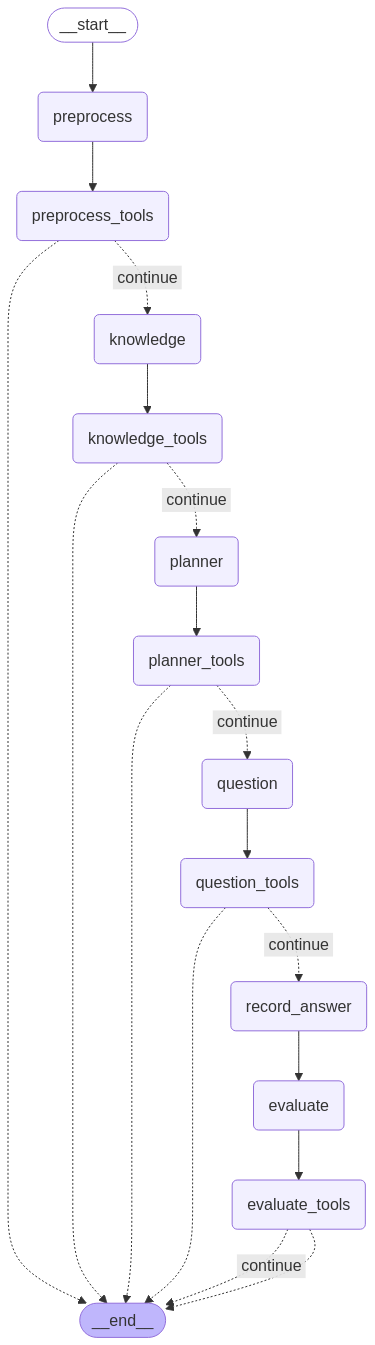

In [5]:
# --- Graph Construction ---
workflow = StateGraph(InterviewState)

# Add nodes for each agent and their tools
workflow.add_node("preprocess", preprocess_agent_node)
workflow.add_node("preprocess_tools", preprocess_tool_node)
workflow.add_node("knowledge", knowledge_agent_node)
workflow.add_node("knowledge_tools", knowledge_tool_node)
workflow.add_node("planner", planner_agent_node)
workflow.add_node("planner_tools", planner_tool_node)
workflow.add_node("question", question_agent_node)
workflow.add_node("question_tools", question_tool_node)
workflow.add_node("record_answer", record_and_transcribe_audio) # Direct tool call node
workflow.add_node("evaluate", evaluation_agent_node)
workflow.add_node("evaluate_tools", evaluation_tool_node)

# Define edges
workflow.set_entry_point("preprocess")

# Preprocessing Agent Logic
workflow.add_edge("preprocess", "preprocess_tools")
workflow.add_conditional_edges(
    "preprocess_tools",
    tools_condition,
    {"continue": "knowledge", END: END} # If tool call needed, loop back via tools_condition, else go to knowledge
)

# Knowledge Agent Logic
workflow.add_edge("knowledge", "knowledge_tools")
workflow.add_conditional_edges(
    "knowledge_tools",
    tools_condition,
    {"continue": "planner", END: END}
)

# Planner Agent Logic
workflow.add_edge("planner", "planner_tools")
workflow.add_conditional_edges(
    "planner_tools",
    tools_condition,
    {"continue": "question", END: END}
)

# Question Agent Logic
workflow.add_edge("question", "question_tools")
workflow.add_conditional_edges(
    "question_tools",
    tools_condition,
    {"continue": "record_answer", END: END} # After question is generated, record answer
)

# Record Answer Node
workflow.add_edge("record_answer", "evaluate") # After recording, go to evaluation

# Evaluation Agent Logic
workflow.add_edge("evaluate", "evaluate_tools")
workflow.add_conditional_edges(
    "evaluate_tools",
    tools_condition,
    {"continue": END, END: END} # End after evaluation
)

# Compile the graph
graph = workflow.compile(checkpointer=memory)

print("Graph compiled successfully!")
# Optional: Visualize the graph
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}. Make sure graphviz and mermaid are installed/configured.")

## 5. Execution and Interaction

Run the graph with user inputs.


In [ ]:
import asyncio
import pprint

# --- Execution ---

# IMPORTANT: Set the path to your Google Cloud credentials file
# This is needed for the record_and_transcribe_audio tool
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "key.json" # Replace with the actual path to your key.json

# --- User Inputs ---
# !!! IMPORTANT: Replace these with the actual paths to your files !!!
resume_file = "placeholder_resume.pdf" # e.g., "/path/to/your/resume.pdf"
jd_file = "amazon-jd.txt"  ., "/path/to/your/job_description.txt"
user_preferred_question_type = "technical" # Options: "technical", "behavioral", "system design", "debugging/problem-solving"

# Create dummy files if they don't exist for the example run
if not os.path.exists(resume_file):
    with open(resume_file, "w") as f:
        f.write("Sample Resume Content: Python Developer with 5 years experience in web development and data analysis.")
if not os.path.exists(jd_file):
     with open(jd_file, "w") as f:
        f.write("Sample Job Description: Looking for a Senior Software Engineer at Google. Requires strong Python skills, experience with distributed systems, and cloud platforms.")

# Define the initial state to start the graph
initial_state = {
    "messages": [],
    "user_resume_path": resume_file,
    "user_jd_path": jd_file,
    "preferred_question_type": user_preferred_question_type,
    "current_agent": "preprocess" # Start with the preprocessing agent
}

# Configuration for the graph run (e.g., unique thread ID)
config = {"configurable": {"thread_id": "interview-prep-thread-1"}}

async def run_graph():
    final_state = None
    print("--- Starting Interview Prep Workflow ---")
    print(f"Resume: {resume_file}")
    print(f"Job Description: {jd_file}")
    print(f"Preferred Question Type: {user_preferred_question_type}")
    print("-" * 30)

    async for event in graph.astream_events(initial_state, config, version="v1"):
        kind = event["event"]
        tags = event.get("tags", [])
        if kind == "on_chat_model_stream":
            content = event["data"]["chunk"].content
            if content:
                # Print LLM tokens as they arrive
                print(content, end="|")
        elif kind == "on_tool_start":
            print(f"\n--- Calling Tool: {event['name']} ---")
            print(f"   Args: {event['data'].get('input')}")
        elif kind == "on_tool_end":
            print(f"--- Tool Result: {event['name']} ---")
            print(f"   Output: {event['data'].get('output')}")
            print("-" * 30)
        elif kind == "on_chain_end":
             # Check if it's the end of a specific agent node run
            if event["name"] in ["preprocess", "knowledge", "planner", "question", "evaluate"]:
                 print(f"\n--- Finished Agent: {event['name']} ---")
                 # pprint.pprint(event['data'].get('output'), indent=2) # Print agent output if needed
                 print("-" * 30)


        # Track the final state
        if kind == "on_graph_end":
            final_state = event['data']['output']


    print("\n--- Workflow Complete ---")

    if final_state:
        print("\n--- Final Results ---")
        # Extract and print key information from the final state
        planner_output = final_state.get('planner_output', {})
        evaluation_output = final_state.get('evaluation_output', {})

        print("\n**Study Plan:**")
        print(planner_output.get('study_plan', 'Not generated.'))

        print("\n**Suggested LeetCode:**")
        pprint.pprint(planner_output.get('suggested_leetcode', 'Not generated.'))

        print("\n**Company Insights:**")
        pprint.pprint(planner_output.get('company_insights_display', 'Not generated.'))

        print(f"\n**Generated Question ({final_state.get('preferred_question_type', 'N/A')}):**")
        print(final_state.get('generated_question', 'Not generated.'))

        print("\n**Your Transcribed Answer:**")
        # The actual transcribed answer isn't directly stored in the state by the tool node,
        # but it was passed to the evaluation agent. We print the placeholder for clarity.
        # In a real UI, you'd capture the output of the 'record_answer' node.
        print(final_state.get('candidate_answer', '[Answer was recorded and passed to evaluation]'))


        print("\n**Evaluation Feedback:**")
        print("\n*Ideal Answer (Placeholder):*")
        print(evaluation_output.get('ideal_answer', 'Not generated.'))
        print("\n*Improved Answer (Placeholder):*")
        print(evaluation_output.get('improved_answer', 'Not generated.'))
        print("\n*Detailed Feedback (Placeholder):*")
        print(evaluation_output.get('detailed_feedback', 'Not generated.'))
    else:
        print("Workflow did not complete successfully or final state not captured.")

# Run the asynchronous function
try:
    asyncio.run(run_graph())
except Exception as e:
    print(f"\nAn error occurred during graph execution: {e}")
